# Visualizing post hoc tests

In this notebook we'll fuse post hoc test (included in the package [scikit-posthocs](https://scikit-posthocs.readthedocs.io/en/latest/) with [statannotations](https://github.com/trevismd/statannotations) to create boxplots with the significant differences annotated. This is a common way to show results when comparing three or more groups in scientific literature, though a simple(r) solution in Python currently lacks.

## Kruskal-Wallis with Post hoc Dunn + statannotations

In this notebook you can see how to implement a Kruskal-Wallis test with Posthoc Dunn and visualize the results using seaborn and statannotations. We'll also check how this is different than the Kruskal-Wallis test included in statannotations.

In [1]:
%load_ext nb_black
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

iris_obj = load_iris()
iris_df = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names)

iris_df["species"] = [iris_obj.target_names[s] for s in iris_obj.target]
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<IPython.core.display.Javascript object>

A bit of code to get the data in the right, format the Kruskal-Wallis test. It requires for each group a list of values. Here a list of list is generated which is then unpacked to arguments for the ```stats.kruskal``` function.

In [2]:
species = np.unique(iris_df.species)

data = []

for s in species:
    data.append(iris_df[iris_df.species == s]["sepal length (cm)"])

<IPython.core.display.Javascript object>

In [3]:
from scipy import stats

stats.kruskal(*data)

KruskalResult(statistic=96.93743600064833, pvalue=8.91873433246198e-22)

<IPython.core.display.Javascript object>

The test is significant, so there is a difference. To find out what difference there is (between which exact species) and additional test, a Posthoc Dunn test is required. The scikit_posthocs package makes this very simple.

In [4]:
from scikit_posthocs import posthoc_dunn

# posthoc dunn test, with correction for multiple testing
dunn_df = posthoc_dunn(
    iris_df, val_col="sepal length (cm)", group_col="species", p_adjust="fdr_bh"
)
dunn_df

,setosa,versicolor,virginica
setosa,1.000000e+00,1.529257e-09,6.000296e-22
versicolor,1.529257e-09,1.000000e+00,2.774866e-04
virginica,6.000296e-22,2.774866e-04,1.000000e+00


<IPython.core.display.Javascript object>

This shows all possible comparisons in a matrix. Though we'll need to extract each pair (once) and get the data in a format compatible with statannotations. This is shown below, the irrelevant part of the matrix is removed, then the matrix is converted to a long format and missing values removed.

In [5]:
remove = np.tril(np.ones(dunn_df.shape), k=0).astype("bool")
dunn_df[remove] = np.nan

molten_df = dunn_df.melt(ignore_index=False).reset_index().dropna()
molten_df

,index,variable,value
3,setosa,versicolor,1.529257e-09
6,setosa,virginica,6.000296e-22
7,versicolor,virginica,2.774866e-04


<IPython.core.display.Javascript object>

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

setosa vs. versicolor: Custom statistical test, P_val:1.529e-09
versicolor vs. virginica: Custom statistical test, P_val:2.775e-04
setosa vs. virginica: Custom statistical test, P_val:6.000e-22


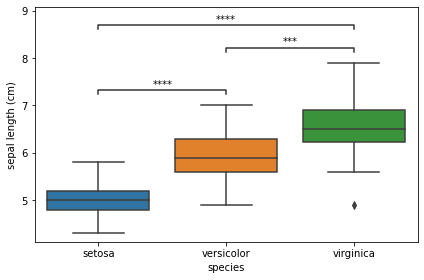

<IPython.core.display.Javascript object>

In [6]:
from statannotations.Annotator import Annotator

ax = sns.boxplot(data=iris_df, x="species", y="sepal length (cm)", order=species)

pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]
p_values = [i[1]["value"] for i in molten_df.iterrows()]

annotator = Annotator(
    ax, pairs, data=iris_df, x="species", y="sepal length (cm)", order=species
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)

plt.tight_layout()
plt.savefig("./img/kruskal-wallis-posthoc.png", dpi=200)

## Comparison with Kruskal Wallis implementation in statannotations

statannotations includes the Kruskal Wallis H test as well, but it is applied on all groups pairwise (note it is not a test for paired samples). Then it applies the selected correction on the p-values. Note that this is not usually how this statistic is applied.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

setosa vs. versicolor: Kruskal-Wallis paired samples with Benjamini-Hochberg correction, P_val:8.130e-14 Stat=5.577e+01
versicolor vs. virginica: Kruskal-Wallis paired samples with Benjamini-Hochberg correction, P_val:5.765e-07 Stat=2.499e+01
setosa vs. virginica: Kruskal-Wallis paired samples with Benjamini-Hochberg correction, P_val:6.212e-17 Stat=6.991e+01


(<AxesSubplot:xlabel='species', ylabel='sepal length (cm)'>,
  <statannotations.Annotation.Annotation at 0x2aaa41c3880>])

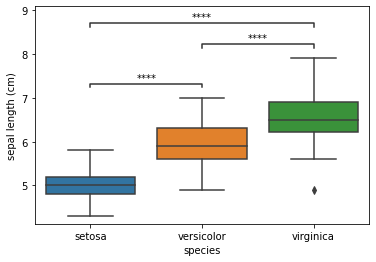

<IPython.core.display.Javascript object>

In [7]:
ax = sns.boxplot(data=iris_df, x="species", y="sepal length (cm)", order=species)

pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]

annotator = Annotator(
    ax, pairs, data=iris_df, x="species", y="sepal length (cm)", order=species
)
annotator.configure(
    test="Kruskal", text_format="star", loc="inside", comparisons_correction="fdr_bh"
)
annotator.apply_and_annotate()

# Conclusion

While statannotations does support the Kruskal-Wallis test, it is implemented a little differently than you typically see in papers. The test is typically done on all groups and tells you if there is **any** difference, the post hoc Dunn test is then used to pick out **which** differences there are. Fortunately statannotations is flexible enough that any test you perform can easily be plotted. As the package scikit_posthocs includes a whole range of tests, including the Tukey HSD test often used following an ANOVA, a few extra lines of code open up a lot of additional problems you can solve an plot using Python.

## ANOVA with Tukey-HSD

In [8]:
from scikit_posthocs import posthoc_tukey

# First we do a oneway ANOVA as implemented in SciPy
print(stats.f_oneway(*data))

tukey_df = posthoc_tukey(iris_df, val_col="sepal length (cm)", group_col="species")
tukey_df

F_onewayResult(statistic=119.26450218450468, pvalue=1.6696691907693826e-31)


,setosa,versicolor,virginica
setosa,1.000,0.001,0.001
versicolor,0.001,1.000,0.001
virginica,0.001,0.001,1.000


<IPython.core.display.Javascript object>

The next steps are the same as with Kruskal Wallis, we turn that matrix into a non-redundant list of pairs and add them in statsannot.

In [9]:
remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan

molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df

,index,variable,value
3,setosa,versicolor,0.001
6,setosa,virginica,0.001
7,versicolor,virginica,0.001


<IPython.core.display.Javascript object>

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

setosa vs. versicolor: Custom statistical test, P_val:1.000e-03
versicolor vs. virginica: Custom statistical test, P_val:1.000e-03
setosa vs. virginica: Custom statistical test, P_val:1.000e-03


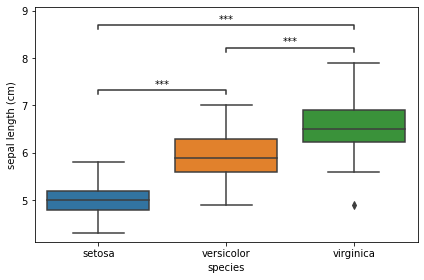

<IPython.core.display.Javascript object>

In [10]:
ax = sns.boxplot(data=iris_df, x="species", y="sepal length (cm)", order=species)

pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]
p_values = [i[1]["value"] for i in molten_df.iterrows()]

annotator = Annotator(
    ax, pairs, data=iris_df, x="species", y="sepal length (cm)", order=species
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)

plt.tight_layout()
plt.savefig("./img/ANOVA-posthoc.png", dpi=200)